In [1]:
# Environment variables
from dotenv import load_dotenv
import os

load_dotenv(".env")

api_key = os.getenv("DEEPSEEK_API_KEY")

In [2]:
# Setup
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import TokenTextSplitter
from langchain_openai import ChatOpenAI

from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import regex as re
import pickle
import uuid

from prompt import *
import rag
import utils

llm = ChatOpenAI(
    model="deepseek-chat",
    api_key=api_key,
    base_url="https://api.deepseek.com/v1"
)

In [3]:
# Load and chunk text
filename = "symposium.txt"
loader = TextLoader(filename)
docs = loader.load()

text_splitter = TokenTextSplitter(chunk_size=1200)
chunks = text_splitter.split_documents(docs)

# Embedding function initialization
embedding_function = OllamaEmbeddings(
    model="bge-m3:567m",
)

C:\Users\28261\AppData\Local\Temp\ipykernel_60684\1356664085.py:10: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embedding_function = OllamaEmbeddings(


In [4]:
# Extraction
tuple_delimiter = PROMPTS["DEFAULT_TUPLE_DELIMITER"] 
record_delimiter = PROMPTS["DEFAULT_RECORD_DELIMITER"]  
completion_delimiter = PROMPTS["DEFAULT_COMPLETION_DELIMITER"] 

prompts = []
for chunk in chunks:
    prompt_template = PROMPTS["entity_extraction"]
    examples_template = PROMPTS["entity_extraction_examples"]
    examples = "\n".join(examples_template).format(
        tuple_delimiter=tuple_delimiter,
        record_delimiter=record_delimiter,
        completion_delimiter=completion_delimiter,
    )
    prompt = prompt_template.format(
        language="English",
        entity_types=PROMPTS["DEFAULT_ENTITY_TYPES"],
        tuple_delimiter=tuple_delimiter,
        record_delimiter=record_delimiter,
        completion_delimiter=completion_delimiter,
        examples=examples,
        input_text=chunk.page_content
    )
    prompts.append(prompt)

os.makedirs("rag_cache", exist_ok=True)

cache_file = os.path.join("rag_cache", f"{filename}_responses.pkl")

if os.path.exists(cache_file):
    print("Loading responses from cache...")
    with open(cache_file, 'rb') as f:
        responses = pickle.load(f)
else:
    print("Fetching responses from LLM and caching...")
    responses = llm.batch(prompts)
    with open(cache_file, 'wb') as f:
        pickle.dump(responses, f)
print("Responses loaded successfully.")

Loading responses from cache...
Responses loaded successfully.


In [5]:
# Parsing extraction output
graph_nodes = defaultdict(lambda: {"descriptions": [], "type": "", "chunk_ids": []})
graph_edges = defaultdict(lambda: {"descriptions": [], "keywords": [], "weight": 1.0, "chunk_ids": []})

for chunk_id, response in enumerate(responses):
    response = response.content
    
    records = utils.split_string_by_multi_markers(response, [record_delimiter, completion_delimiter])

    for record in records:
        match = re.search(r"\((.*)\)", record)
        if not match:
            continue
        record = match.group(1)
        record_attributes = utils.split_string_by_multi_markers(record, tuple_delimiter)

        # Parse entity
        entity_data = utils._handle_single_entity_extraction(record_attributes, llm)
        if entity_data:
            name = entity_data["entity_name"]
            type = entity_data["entity_type"]
            description = entity_data["description"]

            # Deduplication by name
            graph_nodes[name]["descriptions"].append(description)
            graph_nodes[name]["chunk_ids"].append(chunk_id)

        # Parse relation    
        relation_data = utils._handle_single_relation_extraction(record_attributes, llm)
        if relation_data:
            source = relation_data["src_id"]
            target = relation_data["tgt_id"]
            weight = relation_data["weight"]
            description = relation_data["description"]
            keywords = relation_data["keywords"]

            key = (source, target)
            graph_edges[key]["keywords"].append(keywords)
            graph_edges[key]["weight"] = weight

            # Deduplication by key
            graph_edges[key]["descriptions"].append(description)
            graph_edges[key]["chunk_ids"].append(chunk_id)

In [6]:
# Deduplication
deduplication_profiling_cache_file = os.path.join("rag_cache", f"{filename}_deduplicated_profiled.pkl")

temp_entities_vectorstore = Chroma(
        collection_name="temp_entities",
        embedding_function=embedding_function,
        persist_directory="./graph",
        collection_metadata={"hnsw:space": "cosine"}
    )

if os.path.exists(deduplication_profiling_cache_file):
    print("Loading processed graph nodes, edges, and summaries from cache...")
    with open(deduplication_profiling_cache_file, 'rb') as f:
        cached_data = pickle.load(f)
        graph_nodes = cached_data['graph_nodes']
        graph_edges = cached_data['graph_edges']
        summaries = cached_data['summaries']
    print("Success.")
else:
    print("Deduplicating and summarizing...")

    # Clear the temporary collection
    temp_entities_vectorstore.delete_collection()
    
    temp_entities_vectorstore = Chroma(
        collection_name="temp_entities",
        embedding_function=embedding_function,
        persist_directory="./graph",
        collection_metadata={"hnsw:space": "cosine"}
    )
        
    temp_entities_vectorstore.add_texts([str(key) for key in graph_nodes.keys()])

    similarity_threshold = 0.7 # tunable

    # Cluster entities by names
    entity_clusters = {}
    processed_names = set()
    for name in graph_nodes.keys():
        if name in processed_names:
            continue

        search_results = temp_entities_vectorstore.similarity_search_with_relevance_scores(name, k=5)
        
        cluster = [name]
        processed_names.add(name)
        for document, score in search_results:
            variant = document.page_content
            if score > similarity_threshold and name != variant:
                cluster.append(variant)
                processed_names.add(variant)
        entity_clusters[name] = sorted(list(set(cluster)))
    
    name_to_canonical = {}
    for name, variants in entity_clusters.items():
        canonical = name
        for variant in variants:
            name_to_canonical[variant] = canonical
    

    merged_graph_nodes = defaultdict(lambda: {"canonical": "", "type": "", "descriptions": [], "chunk_ids": []})
    merged_graph_edges = defaultdict(lambda: {"descriptions": [], "keywords": [], "weight": 1.0, "count": 0, "chunk_ids": []})

    # Merge entities
    for name, variants in entity_clusters.items():
        descriptions = []
        for variant in variants:
            if variant in graph_nodes:
                descriptions.extend(graph_nodes[variant]["descriptions"])
                if name != variant:
                    print(f"Merged nodes: {name} <- {variant}")

        new_key = tuple(variants)
        merged_graph_nodes[new_key] = {
            "canonical": name,
            "type": graph_nodes[name]["type"],
            "descriptions": descriptions,
            "chunk_ids": graph_nodes[name]["chunk_ids"]
        }
    
    # Reconnect relations
    for key, data in graph_edges.items():
        source, target = key
        canonical_source = name_to_canonical.get(source)
        canonical_target = name_to_canonical.get(target)

        if canonical_source and canonical_target:
            new_key = (canonical_source, canonical_target)
            merged_graph_edges[new_key]["descriptions"].extend(data["descriptions"]) 
            merged_graph_edges[new_key]["keywords"].extend(data["keywords"])
            merged_graph_edges[new_key]["weight"] += data["weight"] 
            merged_graph_edges[new_key]["count"] += 1 
            merged_graph_edges[new_key]["chunk_ids"].extend(data["chunk_ids"])
    
    for key in merged_graph_edges:
        if merged_graph_edges[new_key]["count"] > 1: 
            merged_graph_edges[new_key]["weight"] /= merged_graph_edges[new_key]["count"] 

    graph_nodes = merged_graph_nodes
    graph_edges = merged_graph_edges
    
    print(f"Number of nodes: {len(graph_nodes)}")
    print(f"Number of edges: {len(graph_nodes)}")

    # Summarization
    entity_or_relation_names = []
    entity_or_relation_descriptions = []

    for name, data in graph_nodes.items():
        entity_or_relation_names.append(", ".join(name))
        entity_or_relation_descriptions.append(" ".join(data["descriptions"]))
    for key, data in graph_edges.items():
        entity_or_relation_names.append(" -> ".join(key))
        entity_or_relation_descriptions.append(" ".join(data["descriptions"]))

    summaries = utils._handle_entity_relation_summary(entity_or_relation_names, entity_or_relation_descriptions, filename, llm)

    with open(deduplication_profiling_cache_file, 'wb') as f:
        pickle.dump({
            'graph_nodes': dict(graph_nodes),
            'graph_edges': dict(graph_edges),
            'summaries': summaries
        }, f)
    print("Processed graph data cached successfully.")

Loading processed graph nodes, edges, and summaries from cache...
Success.


In [9]:
# Storage: Networkx and FAISS
graph_storage_file = os.path.join("rag_cache", f"{filename}_graph_cache.pkl")
if os.path.exists(graph_storage_file):
    print("Loading graph and vectorstores from cache...")
    with open(graph_storage_file, 'rb') as f:
        G = pickle.load(f)
    entities_vectorstore = FAISS.load_local("rag_cache/entities_vectorstore", embedding_function, allow_dangerous_deserialization=True)
    relations_vectorstore = FAISS.load_local("rag_cache/relations_vectorstore", embedding_function, allow_dangerous_deserialization=True)
    print("Success.")

else:
    print("Generating graph...")
    G = nx.DiGraph()
    nodes = []
    edges = []
    summary_index = 0

    for name_tuple, data in graph_nodes.items():
        summary = summaries[summary_index].content
        canonical = data["canonical"]

        node_id = str(uuid.uuid4()) # TODO

        # Add node to graph
        G.add_node(
                canonical, # Name as node for now
                graph_id=canonical, 
                type=data['type'], 
                description=summary,
                chunk_ids=data["chunk_ids"]
            )
        
        print(f"Adding node: {canonical} with summary: {summary[:60]}...")
        
        # Prepare node document
        nodes.append(
            Document(
                page_content=summary, 
                metadata={
                    "graph_id": canonical, # Name as id for now
                    "type": data["type"],
                    "value": summary,
                    "chunk_ids": " ".join([str(id) for id in data["chunk_ids"]])
                }
            )
        )
    
        summary_index += 1

    for key, data in graph_edges.items():
        summary = summaries[summary_index].content
        source, target = key

        edge_id = str(uuid.uuid4())

        # Add edge to graph
        G.add_edge(
                source, 
                target, 
                graph_id=edge_id, 
                description=summary, 
                keywords=data['keywords'], 
                weight=float(data['weight']),
                chunk_ids=data["chunk_ids"]
                )
        
        print(f"Adding edge: ({source}, {target}) with summary: {summary[:60]}...")
        
        # Prepare edge document
        edges.append(
            Document(
                page_content=summary,
                metadata={
                    "graph_id": edge_id, 
                    "value": summary,
                    "source": source, 
                    "target": target,
                    "weight": data["weight"],
                    "chunk_ids": " ".join([str(id) for id in data["chunk_ids"]])
                }
            )
        )
        summary_index += 1

    print("Adding nodes and edges to vectorstores...")

    # Populate vectorstore
    entities_vectorstore = FAISS.from_documents(documents=nodes, embedding=embedding_function)
    relations_vectorstore = FAISS.from_documents(documents=edges, embedding=embedding_function)

    entities_vectorstore.save_local("rag_cache/entities_vectorstore")
    relations_vectorstore.save_local("rag_cache/relations_vectorstore")

    print("Caching graph...")
    with open(graph_storage_file, "wb") as f:
        pickle.dump(G, f)
    print("Success.")

Loading graph and vectorstores from cache...
Success.


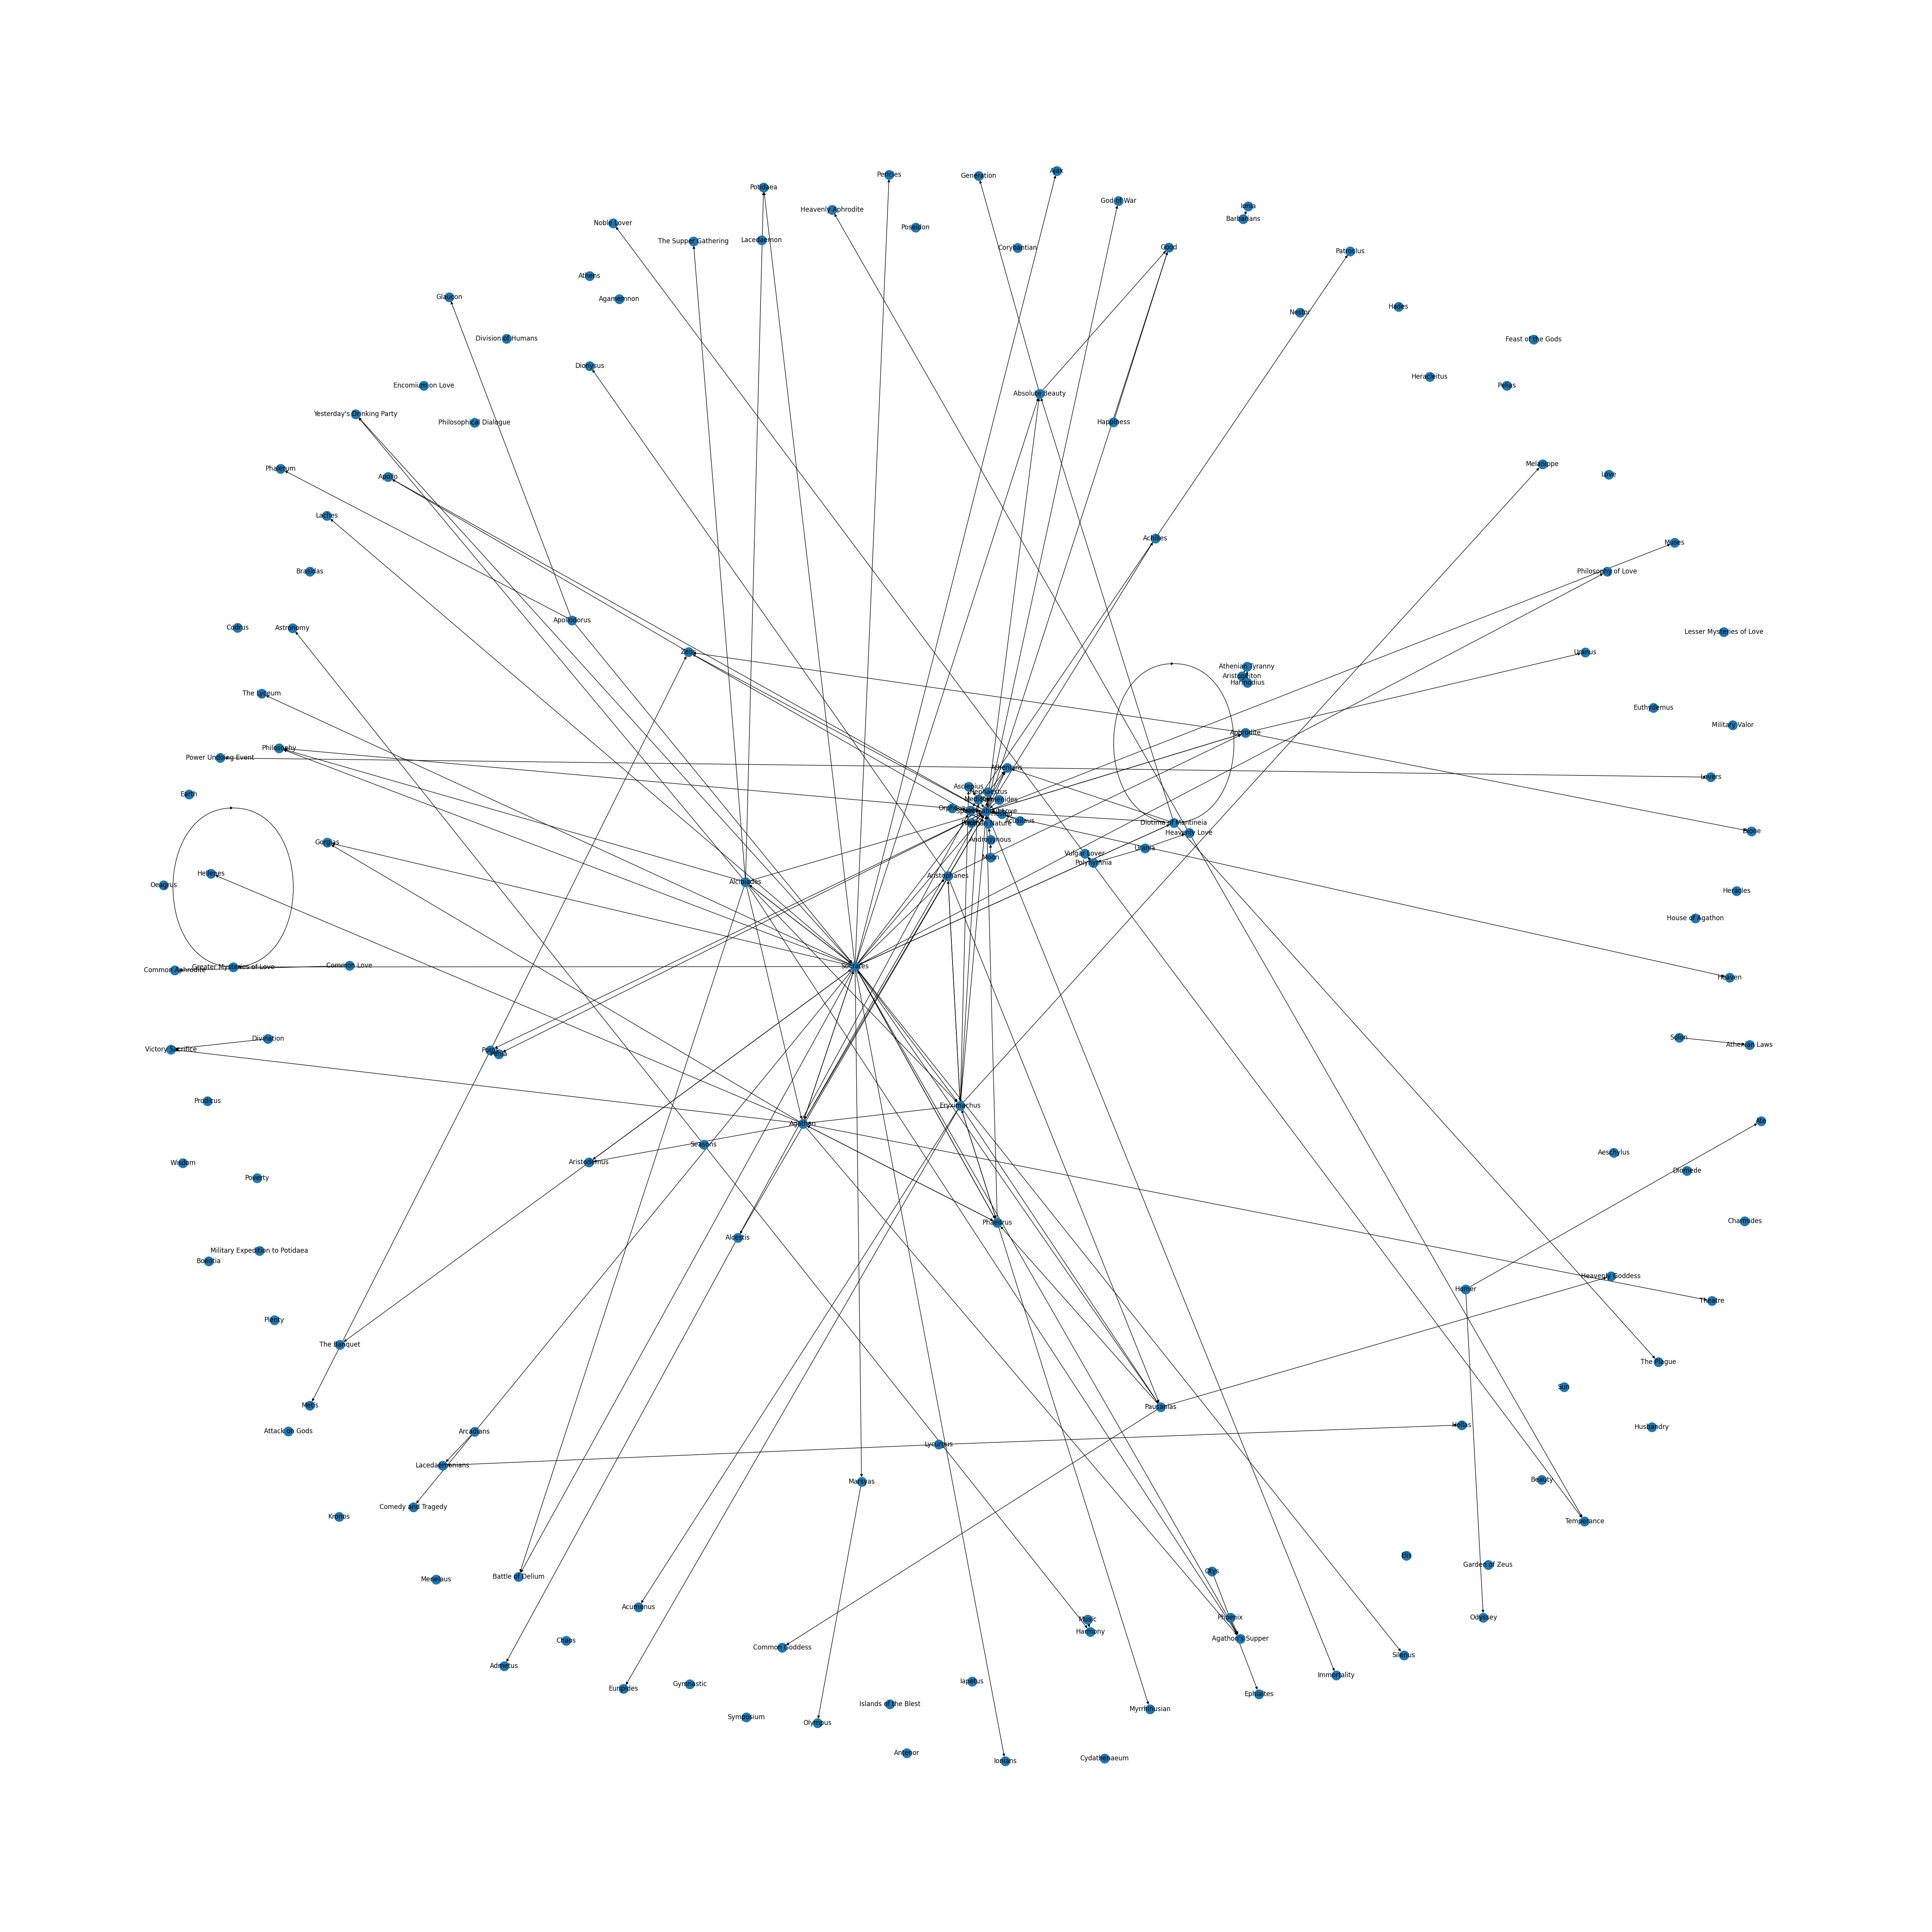

In [10]:
# Graph visualization
plt.figure(figsize=(50, 50))

pos = nx.spring_layout(G, k=0.01, iterations=100, seed=1172)
nx.draw(G, with_labels=True, font_size=12)

plt.show()

In [11]:
# RAG loop
history = []
running = True
while running:
    # Query keywords extraction
    extracted_items = rag.extract_query(history, llm)
    query, query_mode, hl_keywords, ll_keywords = extracted_items

    rag.manage_history(history, "user", str(query))

    # Dual level retrieval
    retrieved_entities_and_relations = rag.dual_level_retrieval(
        G,
        entities_vectorstore,
        relations_vectorstore,
        hl_keywords,
        ll_keywords,
        query_mode
    )

    context_str = rag.build_context(retrieved_entities_and_relations, chunks)

    # Final query
    prompt_template = PROMPTS["rag_response"]
    final_query = prompt_template.format(
        history=rag.build_history_context(history),
        context_data=context_str,
        response_type="",
        user_prompt=""
    )

    # Final generation
    answer = llm.invoke(final_query)
    print(answer)

    rag.manage_history(history, "model", str(answer))

    running = rag.menu()

Enter query mode (local/global).
Any other input defaults to hybrid mode.
Enter your query.
Entering nothing defaults to a preset query.
content="Based on the provided knowledge base from Plato's Symposium, here are the different theories about love presented by the speakers, illustrating how each conveys philosophical thought:\n\n## Comparison of Love Theories in Plato's Symposium\n\n### Phaedrus: Love as a Source of Virtue and Honor\nPhaedrus presents love as the eldest and mightiest of gods, emphasizing its power to inspire virtue and honor. He argues that love creates a sense of shame that prevents dishonorable actions, as lovers would rather be seen by anyone else than their beloved when acting poorly. This theory establishes love as a fundamental social and moral force that drives individuals toward excellence.\n\n### Pausanias: Dual Nature of Love (Heavenly vs. Common)\nPausanias distinguishes between two types of love corresponding to two Aphrodites: Common Love (physical, indi